# Install packages


In [ ]:
!pip install nilearn
# Import packages
import nilearn
from nilearn import image
import numpy as np
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tensorflow as tf
# from tensorflow.keras import regularizers
from collections import Counter
import matplotlib.pyplot as plt #import a module
from matplotlib.ticker import PercentFormatter #PercentFormatter is a function instead of a module
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle
import pandas as pd
import os
import re

     |████████████████████████████████| 10.1 MB 7.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
rootpath=r'/content/drive'
subpath=r'MyDrive/DTI-paper/dataset (1)'
save_path = r'My Drive/DTI-paper/whole_bad'
save_path2 = r'My Drive/DTI-paper/whole_good'
# drive.mount(rootpath)

In [ ]:
save_path = os.path.join(rootpath,save_path)
save_path2 = os.path.join(rootpath,save_path2)
datapath= os.path.join(rootpath,subpath)
os.chdir(save_path)
os.chdir(save_path2)
os.chdir(datapath)

In [ ]:
textfileList = []
for file in os.listdir():
    if file.endswith(".txt"):
        textfileList.append(file)
textfileList = textfileList[:7]
print(textfileList)

['test_S16_man.txt', 'test_1Shell64_DTI_S4_man.txt', 'test_3Shell78_S5_man.txt', 'test_S7_man.txt', 'test_S11_man.txt', '1_man.txt', '2_man.txt']


In [ ]:
# Get nii file names
nameList = []
for file in textfileList:
    nameList.append(file.split('.')[0][:-4])
print(nameList)

['test_S16', 'test_1Shell64_DTI_S4', 'test_3Shell78_S5', 'test_S7', 'test_S11', '1', '2']


In [ ]:
# Import data
dataList = []
index = 0
for file in nameList:
    if os.path.exists(file + '.nii'):
        img = image.smooth_img(os.path.join(datapath, file + '.nii'), fwhm=None)
        dataList.append(img)
    elif os.path.exists(file + '.nii.gz'):
        img = image.smooth_img(os.path.join(datapath, file + '.nii.gz'), fwhm=None)
        dataList.append(img)
    else:
        print("No corresponding data file")
        del textfileList[index]
        continue
    index = index + 1

# Get shape and get minimum dimensions
minLength = []
minHeight = []
slices = []
for file in dataList:
    print(file.shape)
    minLength.append(file.shape[0])
    minHeight.append(file.shape[1])
    slices.append(file.shape[2]*file.shape[3])

minLength = min(minLength)
minHeight = min(minHeight)
print("Number of slices for each file:")
print(slices)
print("Minimum Dimension:")
print((minLength, minHeight))

(140, 140, 81, 104)
(96, 96, 60, 69)
(96, 96, 56, 80)
(96, 96, 56, 80)
(120, 120, 72, 67)
(256, 256, 60, 18)
(256, 256, 59, 18)
Number of slices for each file:
[8424, 4140, 4480, 4480, 4824, 1080, 1062]
Minimum Dimension:
(96, 96)


# Deep Learning models

## Verify the result of the best orginal deep learning model

In [ ]:
tar_path_train_bad = r'My Drive/DTI-paper/whole_bad_train'
tar_path_train_good = r'My Drive/DTI-paper/whole_good_train'

tar_path_test_bad = r'My Drive/DTI-paper/whole_bad_test'
tar_path_test_good = r'My Drive/DTI-paper/whole_good_test'

tar_path_val_bad = r'My Drive/DTI-paper/whole_bad_val'
tar_path_val_good = r'My Drive/DTI-paper/whole_good_val'


tar_path_train_bad = os.path.join(rootpath,tar_path_train_bad)
tar_path_train_good = os.path.join(rootpath,tar_path_train_good)
tar_path_test_bad = os.path.join(rootpath,tar_path_test_bad)
tar_path_test_good = os.path.join(rootpath,tar_path_test_good)
tar_path_val_bad = os.path.join(rootpath,tar_path_val_bad)
tar_path_val_good = os.path.join(rootpath,tar_path_val_good)

os.chdir(tar_path_train_bad)
os.chdir(tar_path_train_good)
os.chdir(tar_path_test_bad)
os.chdir(tar_path_test_good)
os.chdir(tar_path_train_bad)
os.chdir(tar_path_val_bad)

In [ ]:
print(len(os.listdir(tar_path_val_bad)))
print(len(os.listdir(tar_path_val_good)))
print(len(os.listdir(tar_path_train_bad)))
print(len(os.listdir(tar_path_train_good)))
print(len(os.listdir(tar_path_test_bad)))
print(len(os.listdir(tar_path_test_good)))

452
4116
1768
16467
552
5145


In [ ]:
## extracting train/test/val data as array, preprocessing
import re
def extract_x(file_path_good,file_path_bad):
  y_label = []
  index = 0
  index_y = 0
  maching_check = []
  whole_candidate_good = os.listdir(file_path_good) ## in fact  very wired since must follow sequence s7.s11.1.2, key word in 1 too confused
  whole_candidate_bad = os.listdir(file_path_bad) ## in fact  very wired since must follow sequence s7.s11.1.2, key word in 1 too confused
  
  for f in dataList:  ## traver by sequence s7,s11,1,2
      data = [] ## store the array by subject(file)
      filename = textfileList[index:index+1]
      # print(filename, img.shape)
      sub = filename[0].split('_man')[0]
      if sub == '1':
        sub = '1_vol'
      img = f.get_data() # NiFTI to Numpy data type
      sub_belong_good = [string for string in whole_candidate_good if (sub in string)]
      sub_belong_bad = [string for string in whole_candidate_bad if (sub in string)]
      # print('total_file:',len(sub_belong))
      whole_candidate_good = [x for x in whole_candidate_good if x not in sub_belong_good]
      whole_candidate_bad = [x for x in whole_candidate_bad if x not in sub_belong_bad]
      # print('string:',sub)
      for i in sub_belong_good:
        y_label.append(1)
        a = re.split('_vol',i)
        b = a[1].split('_slice')
        vol = int(b[0])-1
        sli = int(b[1].split('.jpeg')[0])-1
        k = img[:,:,sli,vol]
        data.append(k)
      for i in sub_belong_bad:
        y_label.append(0)
        a = re.split('_vol',i)
        b = a[1].split('_slice')
        vol = int(b[0])-1
        sli = int(b[1].split('.jpeg')[0])-1
        k = img[:,:,sli,vol]
        data.append(k)
      temp = np.dstack(data)
      v_min = temp.min(axis=(0, 1), keepdims=True)
      v_max = temp.max(axis=(0, 1), keepdims=True)
      temp = (temp - v_min)/(v_max - v_min)
      print(temp.shape)

      # Down sampling to a same size, e.g., 96x96
      img_new = zoom(temp, (minLength/temp.shape[0], minHeight/temp.shape[1], 1))

      # Combine data
      if index == 0:
          x = img_new
      else:
          x = np.concatenate([x, img_new], axis=2)
      index = index + 1

  # end loop
  x = np.moveaxis(x, -1, 0) #move the third dim to the first dim for running cnn which needs the first dim is the sample#
  x = np.reshape(x, (x.shape[0],minLength, minHeight, 1)) #convert 2D sample to 3D, i.e., add 1 to the 3rd dimension
  print(x.shape)
  y_label = np.array(y_label)
  return x, y_label

In [ ]:
x_val,y_val = extract_x(tar_path_val_good,tar_path_val_bad)

x_train,y_train = extract_x(tar_path_train_good,tar_path_train_bad)
print(x_train.shape)  #the 4th dimension is 1, because cnn needs a 3D image
# print(x)
# (11446, 96, 96, 1)
print(y_train.shape)
# print(y)
# (11446,)

from collections import Counter
print(Counter(y_train))

from collections import Counter
print(Counter(y_val))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


(140, 140, 1291)
(96, 96, 674)
(96, 96, 745)
(96, 96, 729)
(120, 120, 768)
(256, 256, 182)
(256, 256, 169)
(4558, 96, 96, 1)
(140, 140, 5485)
(96, 96, 2678)
(96, 96, 2805)
(96, 96, 2837)
(120, 120, 3061)
(256, 256, 682)
(256, 256, 687)
(18235, 96, 96, 1)
(18235, 96, 96, 1)
(18235,)
Counter({1: 16467, 0: 1768})
Counter({1: 4116, 0: 442})


In [ ]:
x_test,y_test = extract_x(tar_path_test_good,tar_path_test_bad)
print(x_test.shape)  #the 4th dimension is 1, because cnn needs a 3D image
# print(x)
# (11446, 96, 96, 1)
print(y_test.shape)
# print(y)
# (11446,)

from collections import Counter
print(Counter(y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


(140, 140, 1648)
(96, 96, 788)
(96, 96, 930)
(96, 96, 914)
(120, 120, 995)
(256, 256, 216)
(256, 256, 206)
(5697, 96, 96, 1)
(5697, 96, 96, 1)
(5697,)
Counter({1: 5145, 0: 552})


In [ ]:
len_class_0 = sum(y_train==0)
len_class_1 = sum(y_train==1)

ratio = 0.4   # the ratio determines the probability of negative samples
num_sample = int(len_class_1*ratio/(1-ratio))-len_class_0 ## how many images we need to increase
print('sampled class 0 number is :', num_sample)
print('total class 0 number is :', len_class_0)

sampled class 0 number is : 9210
total class 0 number is : 1768


In [ ]:
## auguention on imbalanced data for training
from scipy import ndimage, misc
import matplotlib.pyplot as plt

import random

approach = 'approach1'
if approach == 'approach1':
    print('x_train.shape', x_train.shape)
    # print(x_train)

    len_class_0 = sum(y_train==0)
    len_class_1 = sum(y_train==1)
    print('class 0',len_class_0)
    print('class 1',len_class_1)

    ratio = 0.4   # the ratio determines the probability of negative samples
    num_sample = int(len_class_1*ratio/(1-ratio))-len_class_0 ## how many images we need to increase
    print('Increased class 0 number is :', num_sample)

    select_slices_sum = num_sample/10 ## total 10 rotations degreees, this shows how many slices we need to select

    class_0_index = np.argwhere(y_train == 0)
    class_0_index = np.squeeze(class_0_index) ## array of index of all bad slices within whole training set
    # print(class_0_index)

    def rotation(arr,degree):
        new_arr = ndimage.rotate(arr, degree, reshape=False)
        return new_arr

    # def gasuss_noise(arr, mean=0, var=0.001):
    #     noise = np.random.normal(mean, var ** 0.5, arr.shape)
    #     new_arr = arr + noise
    #     return new_arr

    # def flipLR(arr):
    #     new_arr = np.fliplr(arr)
    #     return new_arr
    # aug_strategies = ['flip180','flipLR','gasuss_noise','none']
    degrees = [-5,-4,-3,-2,-1,1,2,3,4,5] ##0-9 index
    print('select_slices_sum',select_slices_sum)
    # random_index = random_arry[]
    # for i in random_index:
    #     y_train_sample_index = class_0_index[i]
    random_index = random.sample(range(0,len_class_0),int(select_slices_sum)) ## randomly generated 912 indices within 1768 bad slices 
    print('random_index',len(random_index))

    for i in random_index: ## traverse every randomly selected image index
        # y_train_sample_index = random.choice(class_0_index)
        y_train_sample_index = class_0_index[i] ## get corresponding index of bad slice within the whole training set
        sampled_img = x_train[y_train_sample_index,:,:,:]
        print('sampled_img.shape', sampled_img.shape)
        print('select index:',y_train_sample_index)

        for j in range(10): ## every image increase 10 images
          aug = degrees[j]
          # aug = random.choice(degrees)
          print(aug)
          sampled_img_new = rotation(sampled_img,aug)
        # if aug == 'flip180':
        #     sampled_img_new = flip180(sampled_img)
        # elif aug == 'flipLR':
        #     sampled_img_new = flipLR(sampled_img)
        # elif aug == 'gasuss_noise':
        #     sampled_img_new = gasuss_noise(sampled_img)
        # else:
        #     sampled_img_new = sampled_img

          print('sampled_img.shape', sampled_img.shape)
          sampled_img_new = sampled_img_new[np.newaxis,]
          print('sampled_img_new.shape', sampled_img_new.shape)
          x_train = np.concatenate([x_train, sampled_img_new], axis=0)

          y_train = np.concatenate([y_train, [0]], axis=0)

if approach == 'approach2':
    count=0
    # print('x_train.shape', x_train.shape)
    len_class_0 = sum(y_train==0)
    len_class_1 = sum(y_train==1)
    print('class 0',len_class_0)
    print('class 1',len_class_1)

    ratio = 0.5   # the ratio determines the probability of negative samples
    num_sample = int(len_class_1*ratio/(1-ratio))-len_class_0 ## how many images we need to increase
    print('Increased class 0 number is :', num_sample)

    whole_group_1_degrees = int(num_sample/len_class_0)  ## how many augs every image need to increase (whole bad slices)
    seperate_group_2 = num_sample-whole_group_1_degrees*len_class_0 ## how many remaining slices need to be augmented

    class_0_index = np.argwhere(y_train == 0)
    class_0_index = np.squeeze(class_0_index) ## array of index of all bad slices within whole training set
    # print(class_0_index)

    def rotation(arr,degree):
        new_arr = ndimage.rotate(arr, degree, reshape=False)
        return new_arr
    
    degrees = [-5,-4,-3,-2,-1,1,2,3,4,5] ##0-9 index

    random_index_whole_group_degree = random.sample(range(0,10),int(whole_group_1_degrees)) ## randomly generated ~x degrees within total 10 degree
    select_degrees = []
    print('first part',random_index_whole_group_degree)
    for i in class_0_index:   ## traverse every bad image within the whole training set
      sampled_img = x_train[i,:,:,:]
      # print('sampled_img.shape', sampled_img.shape)
      # print('select index:',i)

      for j in random_index_whole_group_degree:
        aug_degree = degrees[j]
        select_degrees.append(aug_degree)
        print(aug_degree)
        sampled_img_new = rotation(sampled_img,aug_degree)

        # print('sampled_img.shape', sampled_img.shape)
        sampled_img_new = sampled_img_new[np.newaxis,]
        # print('sampled_img_new.shape', sampled_img_new.shape)
        count+=1
        x_train = np.concatenate([x_train, sampled_img_new], axis=0)
        y_train = np.concatenate([y_train, [0]], axis=0)
    
    random_index = random.sample(range(0,len_class_0),int(seperate_group_2)) ## randomly generated remaining number indices within 1768 bad slices 
    remain_degrees = [item for item in degrees if item not in select_degrees]

    print('random_index',random_index)
    print('remain_degrees',remain_degrees)
    for i in random_index: ## traverse every randomly selected image index
        y_train_sample_index = class_0_index[i] ## get corresponding index of bad slice within the whole training set
        sampled_img = x_train[y_train_sample_index,:,:,:]
        # print('sampled_img.shape', sampled_img.shape)
        # print('select index:',y_train_sample_index)

        
        aug = random.choice(remain_degrees)
        print(aug)
        sampled_img_new = rotation(sampled_img,aug)
        # print('sampled_img.shape', sampled_img.shape)
        sampled_img_new = sampled_img_new[np.newaxis,]
        # print('sampled_img_new.shape', sampled_img_new.shape)
        count+=1
        x_train = np.concatenate([x_train, sampled_img_new], axis=0)
        y_train = np.concatenate([y_train, [0]], axis=0)

print('*********finished***********')

In [ ]:
## check the current label ratio before sending to the model
### bad
print("Train Proportion:", sum(y_train == 0) / len(y_train))
print("Val Proportion:", sum(y_val == 0) / len(y_val))
print("Test Proportion:", sum(y_test == 0) / len(y_test))

Train Proportion: 0.4
Val Proportion: 0.09697235629662132
Test Proportion: 0.09689310163243813


In [ ]:
## good
print("Train Proportion:", sum(y_train == 1) / len(y_train))
print("Val Proportion:", sum(y_val == 1) / len(y_val))
print("Test Proportion:", sum(y_test == 1) / len(y_test))

Train Proportion: 0.6
Val Proportion: 0.9030276437033786
Test Proportion: 0.9031068983675619


In [ ]:
###***************          VERY IMPORTANT!!!! For switching the label, postive class for bad slices(label 1),negative class for good slices(label 0)
## ***************     Reference here: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

def reverse_array(arrr):
  for i in range(len(arrr)):
    if arrr[i]==0:
      arrr[i]=1
    else:
      arrr[i]=0
reverse_array(y_train)
reverse_array(y_val)
reverse_array(y_test)

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Double check the result for the best model
new_model = tf.keras.models.load_model('/content/drive/MyDrive/DTI-paper/result_saved_best/final_model__method1_r_0.4_lr_0.001_L2_0.02_drop_0.4.h5')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 90, 17)        850       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 17)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 7)         2982      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 7)          0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 4, 7)           0         
                                                                 
 flatten (Flatten)           (None, 112)               0

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

yhat_probs = new_model.predict(x_test, verbose=0)
# predict crisp classes for test set
# yhat_classes = new_model.predict_classes(x_test, verbose=0)
yhat_classes = (yhat_probs > 0.5).astype("int32")

yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]


# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)

# auc
auc = roc_auc_score(y_test, yhat_classes)
print('AUC: %f' % auc)

Precision: 0.844492
Recall: 0.708333
F1 score: 0.770443
Cohens kappa: 0.748184
AUC: 0.847170


## Test the BatchNormalization layer

In [ ]:
from tensorflow.keras import regularizers
# Since batchnormaization is one of the most common layer, 
# we tried to add it to see if it helps improve f1-score obviously.
def cnn_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(17, (7,7),input_shape =(minLength, minHeight, 1), activation='relu', padding='valid'),
      tf.keras.layers.MaxPooling2D(pool_size=(4, 4),strides=(4, 4), padding='valid'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(7, (5,5), activation='relu',padding='valid'),
      tf.keras.layers.MaxPooling2D(pool_size=(4, 4),strides=(4, 4), padding='valid'), 
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100, kernel_regularizer=regularizers.l2(0.02),activation='relu'),
      # tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(1,kernel_regularizer=regularizers.l2(0.02),activation='sigmoid')
      #tf.keras.layers.Dense(2)
  ])
## add L2 regulization lambda=.. 0.001-0.5
## add sampling

  # Model metrics
  
  adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# Training model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = cnn_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 90, 90, 17)        850       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 22, 17)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 22, 22, 17)       68        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 7)         2982      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 7)          0         
 2D)                                                             
                                                        

In [ ]:
mycallbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/My Drive/model{epoch:08d}.h5', 
    period=100,
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1000)]

In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(y_train).reshape(-1),y = y_train.reshape(-1))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.8333333333333334, 1: 1.25}

In [ ]:
class_weights = {0: 0.8333333333333334, 1: 1.25}

In [ ]:
history = model.fit(x_train, y_train, batch_size=800, epochs=35000, callbacks=mycallbacks,validation_data=(x_val, y_val),class_weight=class_weights)

results = model.evaluate(x_test, y_test, verbose=2)


In [ ]:
# Save training log into text file
hist_df = pd.DataFrame(history.history) 
hist_df
hist_df.to_csv("/content/drive/My Drive/train_result.txt", sep='\t', index=False)

# Save testing log into text file
hist_df = pd.DataFrame(results, index=['loss','accuracy']) 
hist_df
hist_df.to_csv("/content/drive/My Drive/test_result.txt", sep='\t', index=False)

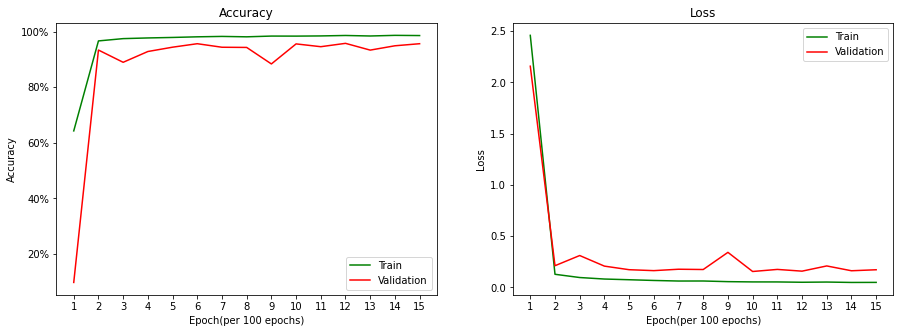

In [ ]:
def plotmodel(trainResult,savedFigName='train_result.png'):  
  train_acc = trainResult.history['accuracy'][::100]
  val_acc = trainResult.history['val_accuracy'][::100]
  train_loss = trainResult.history['loss'][::100]
  val_loss = trainResult.history['val_loss'][::100]
  # train_acc = trainResult.history['accuracy']
  # val_acc = trainResult.history['val_accuracy']
  # train_loss = trainResult.history['loss']
  # val_loss = trainResult.history['val_loss']

  figsize_width=15 #inches
  figsize_height=5 #inches
  x_epochs_ticks_interval=round(len(train_acc)/figsize_width)
  x_epochs = np.arange(1, len(train_acc) + 1, 1) #in the figure, eopch counts from 1
  x_epochs_ticks=np.arange(1, len(train_acc) + 1,x_epochs_ticks_interval)
    
  fig, ax = plt.subplots(1, 2, figsize=(figsize_width, figsize_height)) 

  #left one
  ax[0].set_title('Accuracy')
  ax[0].plot(x_epochs, train_acc, color='green', label='Train')
  ax[0].plot(x_epochs, val_acc, color='red', label='Validation')
  ax[0].legend()
  ax[0].set_xticks(x_epochs_ticks)
  ax[0].set_xlabel('Epoch(per 100 epochs)')
  ax[0].set_ylabel('Accuracy')
  ax[0].yaxis.set_major_formatter(PercentFormatter(1))
  
  #right one
  ax[1].set_title('Loss')
  ax[1].plot(x_epochs, train_loss, color='green', label='Train')
  ax[1].plot(x_epochs, val_loss, color='red', label='Validation')
  ax[1].legend()
  ax[1].set_xticks(x_epochs_ticks)
  ax[1].set_xlabel('Epoch(per 100 epochs)')
  ax[1].set_ylabel('Loss')  

  fig.savefig(savedFigName)


  # Plot the model accuracy
plotmodel(history, os.path.join(datapath,'train_result.png'))

In [ ]:
yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
# yhat_classes = new_model.predict_classes(x_test, verbose=0)
yhat_classes = (yhat_probs > 0.5).astype("int32")

yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]


# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)

# auc
auc = roc_auc_score(y_test, yhat_classes)
print('AUC: %f' % auc)

Precision: 0.820248
Recall: 0.719203
F1 score: 0.766409
Cohens kappa: 0.743156
AUC: 0.851147


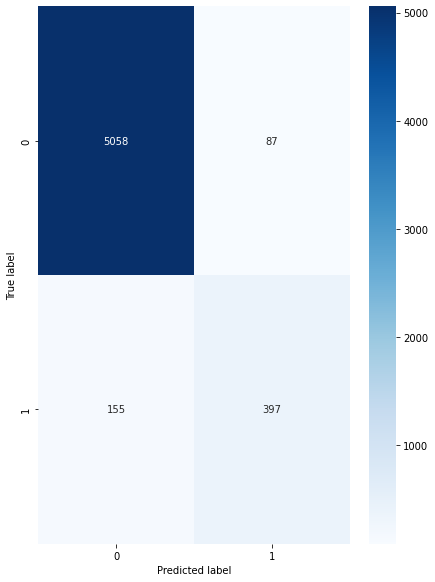

<Figure size 432x288 with 0 Axes>

In [ ]:
# Confusion matrix
def plotcon(model, savedFigName='confusion_matrix.png'):
  yhat_probs = model.predict(x_test, verbose=0)
  pred = (yhat_probs > 0.5).astype("int32") # get predicted values. 
  con_mat = tf.math.confusion_matrix(labels=y_test, predictions=pred).numpy()
  con_mat_df = pd.DataFrame(con_mat, index = [0, 1], columns = [0, 1]) # create a dataframe for plotting

  # Show confusion matrix
  figure = plt.figure(figsize=(6, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues, fmt='g')
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  plt.savefig(savedFigName)

plotcon(model, os.path.join(datapath, 'confusion_matrix.png'))

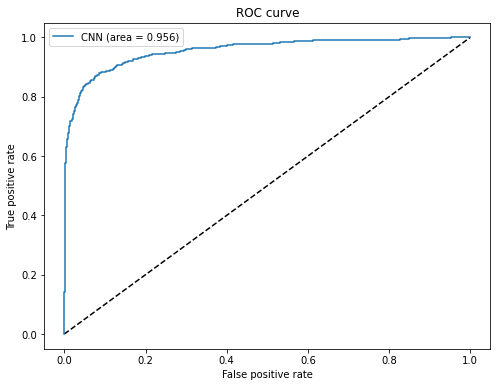

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import auc
from sklearn.dummy import DummyClassifier

# ROC Curve 1
def plotroc(model, savedFigName='roc_curve.png'):
  fpr, tpr, threshold = roc_curve(y_test, model.predict(x_test))
  auc_result = auc(fpr, tpr)
  plt.figure(figsize=(8, 6))
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label='CNN (area = {:.3f})'.format(auc_result))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

  plt.savefig(savedFigName)

plotroc(model, os.path.join(datapath, 'roc_curve.png'))


In [ ]:
#ROC Curve 2
def plotroc(model, savedFigName='roc_curve.png'):
  yhat = model.predict_proba(x_test)
  # retrieve just the probabilities for the positive class
  pos_probs = yhat[:, 0]
  # plot no skill roc curve
  plt.figure(figsize=(8, 6))
  pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
  # calculate roc curve for model
  fpr, tpr, _ = roc_curve(y_test, pos_probs)
  auc_result = auc(fpr, tpr)
  plt.plot(fpr, tpr, label='CNN (area = {:.3f})'.format(auc_result))
  # plot model roc curve  
  # axis labels
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  # show the legend
  plt.title('ROC curve')
  plt.legend(loc='best')
  # show the plot
  pyplot.show()

plotroc(model, os.path.join(datapath, 'roc_curve.png'))

In [ ]:
# Precision Recall Curve
# calculate the precision-recall auc

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc

# P-C Curve 1
def plotroc(model, savedFigName='PC_curve.png'):
  yhat = model.predict(x_test)
  model_probs = yhat[:, 0]
  precision, recall, _ = precision_recall_curve(y_test, model_probs)
  auc_score = auc(recall, precision)
  plt.figure(figsize=(8, 6))
  plt.plot([0, 1], [0, 0], 'k--')
  plt.plot(recall, precision, label='Keras (area = {:.3f})'.format(auc_score))
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend(loc='best')
  plt.show()

  plt.savefig(savedFigName)

plotroc(model, os.path.join(datapath, 'PC_curve.png'))

In [ ]:
# P-C Curve 2
# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
	# plot model precision-recall curve
	precision, recall, _ = precision_recall_curve(test_y, model_probs)
	pyplot.plot(recall, precision, marker='.', label='Precision-Recall')
	# axis labels
	pyplot.xlabel('Recall')
	pyplot.ylabel('Precision')
	# show the legend
	pyplot.legend()
	# show the plot
	pyplot.show()

# no skill model, stratified random class predictions
model1 = DummyClassifier(strategy='stratified')
model1.fit(x_test, y_test)
yhat = model1.predict_proba(x_test)
naive_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)
# fit a model
yhat = model.predict(x_test)
model_probs = yhat[:, 0]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, model_probs)
auc_score = auc(recall, precision)
print('CNN AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(y_test, model_probs)
plt.savefig(os.path.join(datapath, 'PR_curve.png'))

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(x_test, verbose=0)

yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]


# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)


# Traditional machine learning model

We've already see the performance of deep learning models. To better support these models, we built tradtional machine learning models here. SVM is the most common and get the best result here. So we will only show the related code.

## SVM with data augmentation

In [ ]:
tar_path_train_bad = r'MyDrive/DTI-paper/whole_bad_train'
tar_path_train_good = r'MyDrive/DTI-paper/whole_good_train'

tar_path_test_bad = r'MyDrive/DTI-paper/whole_bad_test'
tar_path_test_good = r'My Drive/DTI-paper/whole_good_test'

tar_path_val_bad = r'MyDrive/DTI-paper/whole_bad_val'
tar_path_val_good = r'MyDrive/DTI-paper/whole_good_val'


tar_path_train_bad = os.path.join(rootpath,tar_path_train_bad)
tar_path_train_good = os.path.join(rootpath,tar_path_train_good)
tar_path_test_bad = os.path.join(rootpath,tar_path_test_bad)
tar_path_test_good = os.path.join(rootpath,tar_path_test_good)
tar_path_val_bad = os.path.join(rootpath,tar_path_val_bad)
tar_path_val_good = os.path.join(rootpath,tar_path_val_good)

os.chdir(tar_path_train_bad)
os.chdir(tar_path_train_good)
os.chdir(tar_path_test_bad)
os.chdir(tar_path_test_good)
os.chdir(tar_path_train_bad)
os.chdir(tar_path_val_bad)

In [ ]:
print(len(os.listdir(tar_path_val_bad)))
print(len(os.listdir(tar_path_val_good)))
print(len(os.listdir(tar_path_train_bad)))
print(len(os.listdir(tar_path_train_good)))
print(len(os.listdir(tar_path_test_bad)))
print(len(os.listdir(tar_path_test_good)))

448
4116
1768
16467
552
5145


In [ ]:
import cv2
from scipy import ndimage
IMG_SIZE = 96
x_train = []
y_train = []
for img in os.listdir(tar_path_train_bad):
  img_array=cv2.imread(os.path.join(tar_path_train_bad,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_train.append(new_array)
  y_train.append(0)

for img in os.listdir(tar_path_train_good):
  img_array=cv2.imread(os.path.join(tar_path_train_good,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_train.append(new_array)
  y_train.append(1)

In [ ]:
x_test = []
y_test = []
for img in os.listdir(tar_path_test_bad):
  img_array=cv2.imread(os.path.join(tar_path_test_bad,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_test.append(new_array)
  y_test.append(0)

for img in os.listdir(tar_path_test_good):
  img_array=cv2.imread(os.path.join(tar_path_test_good,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_test.append(new_array)
  y_test.append(1)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
## augmentation on imbalanced data for training
from scipy import ndimage, misc
import matplotlib.pyplot as plt

import random

approach = 'approach1'
ratio = 0.4
if approach == 'approach1':
    # print('x_train.shape', x_train.shape)
    # print(x_train)

    len_class_0 = sum(y_train==0)
    len_class_1 = sum(y_train==1)
    # print('class 0',len_class_0)
    # print('class 1',len_class_1)

    # ratio = 0.4   # the ratio determines the probability of negative samples
    num_sample = int(len_class_1*ratio/(1-ratio))-len_class_0 ## how many images we need to increase
    # print('Increased class 0 number is :', num_sample)

    select_slices_sum = num_sample/10 ## total 10 rotations degreees, this shows how many slices we need to select

    class_0_index = np.argwhere(y_train == 0)
    class_0_index = np.squeeze(class_0_index) ## array of index of all bad slices within whole training set
    # print(class_0_index)

    def rotation(arr,degree):
        new_arr = ndimage.rotate(arr, degree, reshape=False)
        return new_arr

    # def gasuss_noise(arr, mean=0, var=0.001):
    #     noise = np.random.normal(mean, var ** 0.5, arr.shape)
    #     new_arr = arr + noise
    #     return new_arr

    # def flipLR(arr):
    #     new_arr = np.fliplr(arr)
    #     return new_arr
    # aug_strategies = ['flip180','flipLR','gasuss_noise','none']
    degrees = [-5,-4,-3,-2,-1,1,2,3,4,5] ##0-9 index
    print('select_slices_sum',select_slices_sum)
    # random_index = random_arry[]
    # for i in random_index:
    #     y_train_sample_index = class_0_index[i]
    random_index = random.sample(range(0,len_class_0),int(select_slices_sum)) ## randomly generated 912 indices within 1768 bad slices 
    print('random_index',len(random_index))

    for i in random_index: ## traverse every randomly selected image index
        # y_train_sample_index = random.choice(class_0_index)
        y_train_sample_index = class_0_index[i] ## get corresponding index of bad slice within the whole training set
        sampled_img = x_train[y_train_sample_index,:,:,:]
        # print('sampled_img.shape', sampled_img.shape)
        # print('select index:',y_train_sample_index)

        for j in range(10): ## every image increase 10 images
          aug = degrees[j]
          # aug = random.choice(degrees)
          # print(aug)
          sampled_img_new = rotation(sampled_img,aug)
        # if aug == 'flip180':
        #     sampled_img_new = flip180(sampled_img)
        # elif aug == 'flipLR':
        #     sampled_img_new = flipLR(sampled_img)
        # elif aug == 'gasuss_noise':
        #     sampled_img_new = gasuss_noise(sampled_img)
        # else:
        #     sampled_img_new = sampled_img

          # print('sampled_img.shape', sampled_img.shape)
          sampled_img_new = sampled_img_new[np.newaxis,]
          # print('sampled_img_new.shape', sampled_img_new.shape)
          x_train = np.concatenate([x_train, sampled_img_new], axis=0)

          y_train = np.concatenate([y_train, [0]], axis=0)

if approach == 'approach2':
    count=0
    # print('x_train.shape', x_train.shape)
    len_class_0 = sum(y_train==0)
    len_class_1 = sum(y_train==1)
    print('class 0',len_class_0)
    print('class 1',len_class_1)

    # ratio = 0.5   # the ratio determines the probability of negative samples
    num_sample = int(len_class_1*ratio/(1-ratio))-len_class_0 ## how many images we need to increase
    print('Increased class 0 number is :', num_sample)

    whole_group_1_degrees = int(num_sample/len_class_0)  ## how many augs every image need to increase (whole bad slices)
    seperate_group_2 = num_sample-whole_group_1_degrees*len_class_0 ## how many remaining slices need to be augmented

    class_0_index = np.argwhere(y_train == 0)
    class_0_index = np.squeeze(class_0_index) ## array of index of all bad slices within whole training set
    # print(class_0_index)

    def rotation(arr,degree):
        new_arr = ndimage.rotate(arr, degree, reshape=False)
        return new_arr
    
    degrees = [-5,-4,-3,-2,-1,1,2,3,4,5] ##0-9 index

    random_index_whole_group_degree = random.sample(range(0,10),int(whole_group_1_degrees)) ## randomly generated ~x degrees within total 10 degree
    select_degrees = []
    print('first part',random_index_whole_group_degree)
    for i in class_0_index:   ## traverse every bad image within the whole training set
      sampled_img = x_train[i,:,:,:]
      # print('sampled_img.shape', sampled_img.shape)
      # print('select index:',i)

      for j in random_index_whole_group_degree:
        aug_degree = degrees[j]
        select_degrees.append(aug_degree)
        # print(aug_degree)
        sampled_img_new = rotation(sampled_img,aug_degree)

        # print('sampled_img.shape', sampled_img.shape)
        sampled_img_new = sampled_img_new[np.newaxis,]
        # print('sampled_img_new.shape', sampled_img_new.shape)
        count+=1
        x_train = np.concatenate([x_train, sampled_img_new], axis=0)
        y_train = np.concatenate([y_train, [0]], axis=0)
    
    random_index = random.sample(range(0,len_class_0),int(seperate_group_2)) ## randomly generated remaining number indices within 1768 bad slices 
    remain_degrees = [item for item in degrees if item not in select_degrees]

    # print('random_index',random_index)
    # print('remain_degrees',remain_degrees)
    for i in random_index: ## traverse every randomly selected image index
        y_train_sample_index = class_0_index[i] ## get corresponding index of bad slice within the whole training set
        sampled_img = x_train[y_train_sample_index,:,:,:]
        # print('sampled_img.shape', sampled_img.shape)
        # print('select index:',y_train_sample_index)

        
        aug = random.choice(remain_degrees)
        print(aug)
        sampled_img_new = rotation(sampled_img,aug)
        # print('sampled_img.shape', sampled_img.shape)
        # sampled_img_new = sampled_img_new[np.newaxis,]
        # print('sampled_img_new.shape', sampled_img_new.shape)
        count+=1
        x_train = np.concatenate([x_train, sampled_img_new], axis=0)
        y_train = np.concatenate([y_train, [0]], axis=0)

print('*********finished***********')

select_slices_sum 921.0
random_index 921
*********finished***********


In [ ]:
###***************          VERY IMPORTANT!!!! For switching the label, postive class for bad slices(label 1),negative class for good slices(label 0)
## ***************     Reference here: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

def reverse_array(arrr):
  for i in range(len(arrr)):
    if arrr[i]==0:
      arrr[i]=1
    else:
      arrr[i]=0
reverse_array(y_train)
# reverse_array(y_val)
reverse_array(y_test)

In [ ]:
## check the current label ratio before sending to the model
### bad
print("Train Proportion:", sum(y_train == 1) / len(y_train))
# print("Val Proportion:", sum(y_val == 1) / len(y_val))
print("Test Proportion:", sum(y_test == 1) / len(y_test))

Train Proportion: 0.4
Test Proportion: 0.09689310163243813


In [ ]:
nums = x_train.shape[0]
tmp = np.reshape(x_train,(nums,-1))
pd.DataFrame(tmp).to_csv("x_train'.csv")

In [ ]:
pd.DataFrame(y_test).to_csv("y_train'.csv")

In [ ]:
nums2 = x_test.shape[0]
tmp2 = np.reshape(x_test,(nums2,-1))
np.savetxt("x_test.csv", tmp2, delimiter=",")

In [ ]:
pd.DataFrame(y_test).to_csv("y_test.csv")

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(tmp, y_train)

SVC()

In [ ]:
y_pred = clf.predict(tmp2)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

Recall: 0.752
Precision: 0.797
F1 Score: 0.774


## SVM without data augmentation

### Do not add validation dateset to training set

In [ ]:
tar_path_train_bad = r'MyDrive/DTI-paper/whole_bad_train'
tar_path_train_good = r'MyDrive/DTI-paper/whole_good_train'

tar_path_test_bad = r'MyDrive/DTI-paper/whole_bad_test'
tar_path_test_good = r'My Drive/DTI-paper/whole_good_test'

tar_path_val_bad = r'MyDrive/DTI-paper/whole_bad_val'
tar_path_val_good = r'MyDrive/DTI-paper/whole_good_val'


tar_path_train_bad = os.path.join(rootpath,tar_path_train_bad)
tar_path_train_good = os.path.join(rootpath,tar_path_train_good)
tar_path_test_bad = os.path.join(rootpath,tar_path_test_bad)
tar_path_test_good = os.path.join(rootpath,tar_path_test_good)
tar_path_val_bad = os.path.join(rootpath,tar_path_val_bad)
tar_path_val_good = os.path.join(rootpath,tar_path_val_good)

os.chdir(tar_path_train_bad)
os.chdir(tar_path_train_good)
os.chdir(tar_path_test_bad)
os.chdir(tar_path_test_good)
os.chdir(tar_path_train_bad)
os.chdir(tar_path_val_bad)

In [ ]:
print(len(os.listdir(tar_path_val_bad)))
print(len(os.listdir(tar_path_val_good)))
print(len(os.listdir(tar_path_train_bad)))
print(len(os.listdir(tar_path_train_good)))
print(len(os.listdir(tar_path_test_bad)))
print(len(os.listdir(tar_path_test_good)))

452
4116
1768
16467
552
5145


In [ ]:
import cv2
from scipy import ndimage
IMG_SIZE = 96
x_train = []
y_train = []
for img in os.listdir(tar_path_train_bad):
  img_array=cv2.imread(os.path.join(tar_path_train_bad,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_train.append(new_array)
  y_train.append(0)

for img in os.listdir(tar_path_train_good):
  img_array=cv2.imread(os.path.join(tar_path_train_good,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_train.append(new_array)
  y_train.append(1)

In [ ]:
x_test = []
y_test = []
for img in os.listdir(tar_path_test_bad):
  img_array=cv2.imread(os.path.join(tar_path_test_bad,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_test.append(new_array)
  y_test.append(0)

for img in os.listdir(tar_path_test_good):
  img_array=cv2.imread(os.path.join(tar_path_test_good,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_test.append(new_array)
  y_test.append(1)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
def reverse_array(arrr):
  for i in range(len(arrr)):
    if arrr[i]==0:
      arrr[i]=1
    else:
      arrr[i]=0
reverse_array(y_train)
# reverse_array(y_val)
reverse_array(y_test)

In [ ]:
## check the current label ratio before sending to the model
### bad
print("Train Proportion:", sum(y_train == 1) / len(y_train))
# print("Val Proportion:", sum(y_val == 1) / len(y_val))
print("Test Proportion:", sum(y_test == 1) / len(y_test))

Train Proportion: 0.09695640252262133
Test Proportion: 0.09689310163243813


In [ ]:
nums = x_train.shape[0]
tmp = np.reshape(x_train,(nums,-1))
# pd.DataFrame(tmp).to_csv("x_train.csv")
# pd.DataFrame(y_test).to_csv("y_train.csv")

In [ ]:
nums2 = x_test.shape[0]
tmp2 = np.reshape(x_test,(nums2,-1))
# np.savetxt("x_test.csv", tmp2, delimiter=",")
# pd.DataFrame(y_test).to_csv("y_test.csv")

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(tmp, y_train)

SVC()

In [ ]:
y_pred = clf.predict(tmp2)
y_train_pred = clf.predict(tmp)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('########### train ############')
print('Recall: %.3f' % recall_score(y_train, y_train_pred))
print('Precision: %.3f' % precision_score(y_train, y_train_pred))
print('F1 Score: %.3f' % f1_score(y_train, y_train_pred))

print('########### test ############')
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

########### train ############
Recall: 0.471
Precision: 0.994
F1 Score: 0.639
########### test ############
Recall: 0.458
Precision: 0.992
F1 Score: 0.627


### Add validation dateset to training set


In [ ]:
tar_path_train_bad = r'MyDrive/DTI-paper/whole_bad_train'
tar_path_train_good = r'MyDrive/DTI-paper/whole_good_train'

tar_path_test_bad = r'MyDrive/DTI-paper/whole_bad_test'
tar_path_test_good = r'My Drive/DTI-paper/whole_good_test'

tar_path_val_bad = r'MyDrive/DTI-paper/whole_bad_val'
tar_path_val_good = r'MyDrive/DTI-paper/whole_good_val'


tar_path_train_bad = os.path.join(rootpath,tar_path_train_bad)
tar_path_train_good = os.path.join(rootpath,tar_path_train_good)
tar_path_test_bad = os.path.join(rootpath,tar_path_test_bad)
tar_path_test_good = os.path.join(rootpath,tar_path_test_good)
tar_path_val_bad = os.path.join(rootpath,tar_path_val_bad)
tar_path_val_good = os.path.join(rootpath,tar_path_val_good)

os.chdir(tar_path_train_bad)
os.chdir(tar_path_train_good)
os.chdir(tar_path_test_bad)
os.chdir(tar_path_test_good)
os.chdir(tar_path_train_bad)
os.chdir(tar_path_val_bad)

In [ ]:
print(len(os.listdir(tar_path_val_bad)))
print(len(os.listdir(tar_path_val_good)))
print(len(os.listdir(tar_path_train_bad)))
print(len(os.listdir(tar_path_train_good)))
print(len(os.listdir(tar_path_test_bad)))
print(len(os.listdir(tar_path_test_good)))

452
4116
1768
16467
552
5145


In [ ]:
import cv2
from scipy import ndimage
IMG_SIZE = 96
x_train = []
y_train = []
for img in os.listdir(tar_path_train_bad):
  img_array=cv2.imread(os.path.join(tar_path_train_bad,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_train.append(new_array)
  y_train.append(0)

for img in os.listdir(tar_path_train_good):
  img_array=cv2.imread(os.path.join(tar_path_train_good,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_train.append(new_array)
  y_train.append(1)


for img in os.listdir(tar_path_val_good):
  img_array=cv2.imread(os.path.join(tar_path_val_good,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_train.append(new_array)
  y_train.append(1)

for img in os.listdir(tar_path_val_bad):
  if '.jpeg' in img:
    img_array=cv2.imread(os.path.join(tar_path_val_bad,img))
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    x_train.append(new_array)
    y_train.append(0)

In [ ]:
x_test = []
y_test = []
for img in os.listdir(tar_path_test_bad):
  img_array=cv2.imread(os.path.join(tar_path_test_bad,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_test.append(new_array)
  y_test.append(0)

for img in os.listdir(tar_path_test_good):
  img_array=cv2.imread(os.path.join(tar_path_test_good,img))
  new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
  x_test.append(new_array)
  y_test.append(1)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
def reverse_array(arrr):
  for i in range(len(arrr)):
    if arrr[i]==0:
      arrr[i]=1
    else:
      arrr[i]=0
reverse_array(y_train)
# reverse_array(y_val)
reverse_array(y_test)

In [ ]:
## check the current label ratio before sending to the model
### bad
print("Train Proportion:", sum(y_train == 1) / len(y_train))
# print("Val Proportion:", sum(y_val == 1) / len(y_val))
print("Test Proportion:", sum(y_test == 1) / len(y_test))

Train Proportion: 0.09695959285745624
Test Proportion: 0.09689310163243813


In [ ]:
nums = x_train.shape[0]
tmp = np.reshape(x_train,(nums,-1))

nums2 = x_test.shape[0]
tmp2 = np.reshape(x_test,(nums2,-1))

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(tmp, y_train)

SVC()

In [ ]:
y_pred = clf.predict(tmp2)
y_train_pred = clf.predict(tmp)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print('########### train ############')
print('Recall: %.3f' % recall_score(y_train, y_train_pred))
print('Precision: %.3f' % precision_score(y_train, y_train_pred))
print('F1 Score: %.3f' % f1_score(y_train, y_train_pred))

print('########### test ############')
print('Recall: %.3f' % recall_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_pred))

########### train ############
Recall: 0.498
Precision: 0.995
F1 Score: 0.664
########### test ############
Recall: 0.478
Precision: 0.992
F1 Score: 0.645
